# Exercises

## Exercise 1: Image characteristics
---

**A.** Distiguishing pixels   

Fluctuations in the activitation of the neuron can be directly observed on the video or in a temporal trace plot of each pixel. Plotting the temporal trace will allow us to see the calcium transient dinamic, if a pixel belonging to a neuron is selected. 

* Select a set of *N* random pixels from the ROI and plot the temporal evolution of pixel value. If the random pixels are choosen from an active neuron, you will be able to see the calcium transcient dynamic. Try this a few time to appreciate the results.

In [1]:
import numpy as np
import pylab as pl
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import psutil
from pathlib import Path
import os

# CaImAn funtions and objects
import caiman as cm
from caiman.motion_correction import MotionCorrect, high_pass_filter_space
from caiman.source_extraction.cnmf import params as params
from caiman.source_extraction import cnmf
from caiman.source_extraction.cnmf.cnmf import load_CNMF

import sys
import os
sys.path.append(os.path.abspath("code"))
from utils import download_data
import auxiliary_functions as aux

import random

import seaborn as sns
sns.set_theme(context='notebook',style='white',font_scale=1.5)

In [2]:
# download data for the lesson (this can take a few minutes)
download_data('https://surfdrive.surf.nl/files/index.php/s/yQT6yv34jDu6csE')

In [3]:
input_tif_file_path = 'data/caiman_video_trial_0.tif'  
movie = cm.load(input_tif_file_path)

In [4]:
np.shape(movie) #[t, x, y]

(500, 300, 400)

In [25]:
pixels_x = 500
pixels_y = 300
N = 10
pixel_x_rand = random.sample(range(pixels_x), N)
pixel_y_rand = random.sample(range(pixels_y), N)

Text(0, 0.5, 'Activity')

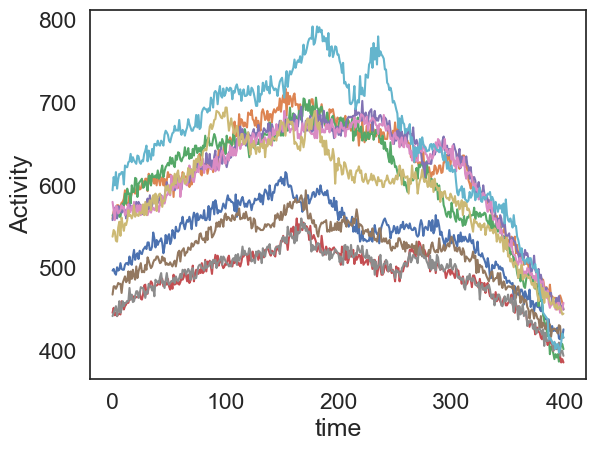

In [26]:
for i in range(N):
    plt.plot(movie[pixel_x_rand[i],pixel_y_rand[i],:])

plt.xlabel(r'time')
plt.ylabel(r'Activity')

We observe here multiple (20) pixels over time. Over all we see a first increasing (until around 180 timesteps) and then decreasing (until the end) trend for all pixels. But also some faster, spike like curves and obviously some noise.

**B.** Temporal statistics of pixel activation
 * For the selected pixels, plot the histogram of pixel value. What are the difference in different regions?, and how can that help to distinguish a pixel that belongs to aneuron from a background pixel?

* If we can already see the calcium traces from individual pixels, why do we need to run source extraction to segment the neurons? Why, as a starter, would not be a good idea to work directly with the temporal traces of the pixels? 

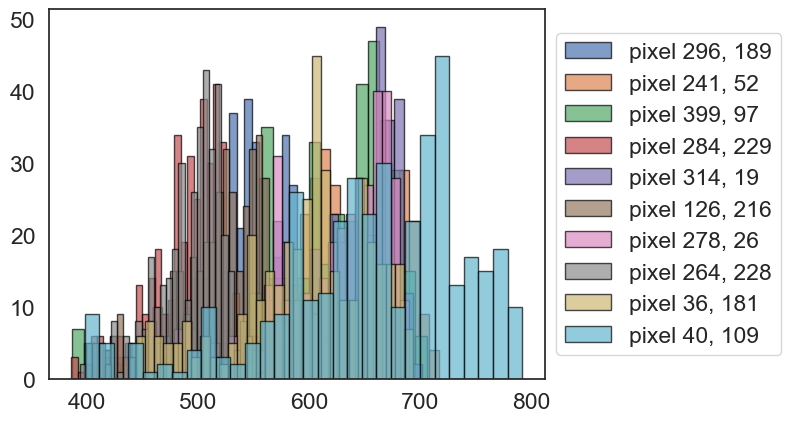

In [29]:
for i in range(N):
    plt.hist(movie[pixel_x_rand[i],pixel_y_rand[i],:],  edgecolor='black',bins=30,alpha =0.7,label = "pixel "+str(pixel_x_rand[i])+", "+str(pixel_y_rand[i]))

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

We observe different knds of distributions here, just like in the plots above. Pixels that were in genrell more active are naturally located more on the right hand side. Since a pixel likated in a neuron is expected to be sometimes active and sometimes not, we could assume that neuron pixels show a wider distribution due to being turend on or off at different times.

Pixels itself are relatively noisy and it could be that we observe neuron-like behaviour in a single pixel, because of distortions or noise and missinterpret it as a neuron spiking. This can be avoided if we concider the surrounding pixels as well, as described in the calcium_imaging notebook. Single pixels also dont allow us to improve the signal to noise ratio or the 'crispness' because we have no way of knowing if pixels, that fire close together might belong to overlapping neurons instead to to the same one.

## Exercise 2: motion correction parameters
---

One parameter that impacts motion correction performance is the size of the spatial filter that is applyed to the video.

* Use the following function from CaImAn and plot the result of different space filtering applyed to a single frame of the video:from caiman.motion_correction import high_pass_filter_space

* How will this filtering affect the measure of crispness?

* Acording to Pnevmatikakis et al, which other factors are relevant for pw-rigid motion correction?

- Explore the impact of different parameters in the output of motion correction algorithm by measuring crispness in the correlation image of the final outcome. Particularly measure the effect of different spatial filter size by applying motion correction algorithm multiple times and computing the crispness of the output video. 

- Display all crispness values for rigid and not rigid motion correction and plot them agains gSig_filters values.

- If possible, show the impact of the crispness value that comes from changing other relevant paraments.

*Note1: The is no need to save all the motion corrected movies, just save the cripsness values.*

*Note2: gSig_filters is an optional range of posible values, but if your computer gets to slow in the computation reduce the range.*


In [30]:
from caiman.motion_correction import high_pass_filter_space

In [31]:
frame = movie[100,:,:]

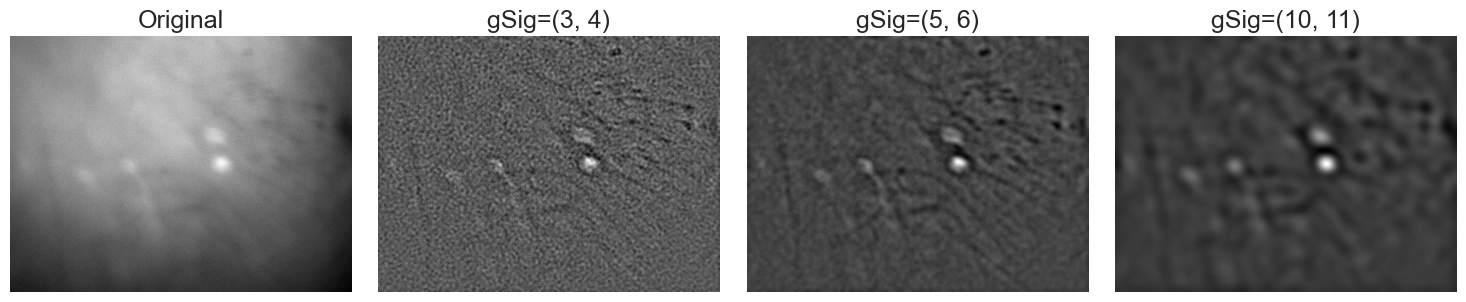

In [35]:
parameters_motion_correction = { 'pw_rigid': True,       # flag for performing piecewise-rigid motion correction (otherwise just rigid)
                                'gSig_filt': (5, 5),     # size of high pass spatial filtering, used in 1p data
                                'max_shifts': (25, 25),  # maximum allowed rigid shift in pixels (view the movie to get a sense of motion)
                                'niter_rig': 1 ,
                                'strides': (48, 48),     # create a new patch every x pixels for pw-rigid correction
                                'overlaps': (96, 96),    # overlap between pathes (size of patch strides+overlaps)
                                'upsample_factor_grid': 1,
                                'num_frames_split': 80,  # length in frames of each chunk of the movie (to be processed in parallel)
                                'max_deviation_rigid': 15, # maximum deviation allowed for patch with respect to rigid shifts
                                'shifts_opencv': True, 
                                'use_cuda': False, 
                                'nonneg_movie': True,
                                'border_nan': 'copy'}



filters = [(3, 4), (5, 6), (10, 11)]
filtered_frames = [high_pass_filter_space(frame, gSig_filt=s) for s in filters]

fig, axes = plt.subplots(1, len(filters) + 1, figsize=(15, 5))

axes[0].imshow(frame, cmap='gray')
axes[0].set_title('Original')
axes[0].axis('off')

for i, (filt_frame, sig) in enumerate(zip(filtered_frames, filters)):
    axes[i + 1].imshow(filt_frame, cmap='gray')
    axes[i + 1].set_title(f'gSig={sig}')
    axes[i + 1].axis('off')

plt.tight_layout()
plt.show()

We observe that the crispness first increases but then decreases again if the filter gets too high. From interpreting it with the eye it look like gSig=(3,4) is the most crisp here.

## Exercise 3: Source extraction parameters 
---

* For a fixed minimum correlation value (ie 0.6) select a range of possible PNR minimun values and study the impact of those in the final source extraction output.

* For a fixed value of PNR (ie 6) select a range of minimum correlation valur and study the impact of those in the final source extraction output.

* How do these paramenters affect the spatial sparcity of the output? Which set of parameter selection procedes the higher number of neurons? Is maximal number of neurons always better? Why?  

* Generate a plot of number of neurons vs PNR (or min corr value) to show how these parameters affect the source extracted signals.

* Are the temporal traces affected by these parameters?

* For different PNR and minimum correlation value plot the correlation image and the selected cells.